<a href="https://www.kaggle.com/code/kapusharinka/spam-detection?scriptVersionId=173295810" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
from pprint import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Articles about ML
https://github.com/christianversloot/machine-learning-articles/tree/main

# Data preprocessing
## Preparing datasets

In [47]:
data = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10000 non-null  int64 
 1   Unnamed: 0.1  10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [48]:
# delete unneeded columns
data.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)

In [49]:
# Remove emails with body longer than 10000
data = data[data['Body'].apply(lambda x: len(str(x)) <= 10000)]

In [50]:
# take a fraction
# data = data.sample(frac=0.7)
# remove missing values (NaN)
data.dropna(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9882 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    9882 non-null   object
 1   Label   9882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 231.6+ KB


,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [51]:
data.describe(include='object')

,Body
count,9882
unique,9582
top,Subject: \n
freq,16


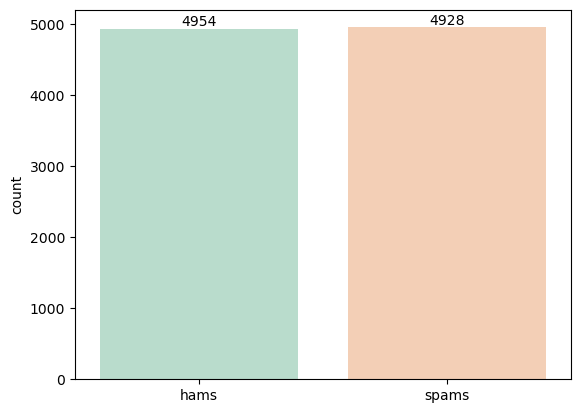

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x=data["Label"], palette=("Pastel2"))
abs_values = data["Label"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_xticklabels(['hams', 'spams'])

plt.xlabel(None)
plt.show()

In [53]:
emails = data["Body"]

Here I'm removing unneeded characters, like HTML tags, emails etc.

In [54]:
import re

# remove email addresses
emails = [re.sub('\S*@\S*\s?', '', text) for text in emails]
# remove url links
emails = [re.sub('\S*(http[s]?://|www\.)\S*', '', text) for text in emails]
# remove HTML tags
emails = [re.sub(r"'<.*?>'", "", text) for text in emails]
# remove special characters and numbers
emails = [re.sub("[^a-zA-Z]"," ",text) for text in emails]
# remove too short (2- characters) words
emails = [re.sub(r"\b\w{1,2}\b", "",text) for text in emails]
# and too long (17+ characters) 
emails = [re.sub(r"\b\w{17,}\b", "",text) for text in emails]
# remove multiple spaces
emails = [re.sub(' +', ' ', text).strip() for text in emails]
# lower
emails = [text.lower() for text in emails]

emails[0]

'subject stock promo mover cwtd urgent investor trading alert weekly stock pick china world trade corp ticker cwtd breaking news china world trade corp enters into agreement acquire majority stake ceo clubs china limited the ceo clubs tianhe guangzhou china market wire apr china world trade corp otc cwtd news announced today that has entered into agreement acquired majority stake ceo clubs china limited the ceo clubs hong kong corporation with authorized chapter operate under the ceo clubs trademarks the greater china region including the prc hong kong and taiwan china world trade corp symbol cwtd price shares out million market capitalization million significant revenue growth average industry rating strong buy days trading target day trading target cwtd our play the month stock pick here are few simple reasons why one would own china world trade corp china world trade corp announced today that has entered into agreement acquired majority stake ceo clubs china limited the ceo clubs ho

## Tokenization and lemmatization
Tokenization: [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition) (page 180)
<ul>
    <li>one-hot encoding of tokens</li>
    <li>token embedding</li>
</ul>
For more, look at <i>Deep Learning</i> section below.

We can choose between stemming or lemmatization - lemmatizators are slower, but change tenses and nouns. <br/>
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

Firstly I used NLTK lemmatization, but it is very slow on my computer, so I tried SpaCy instead (https://spacy.io).

In [55]:
custom_stopwords = ['subject', 'empty', 'email', 'mail', 'enron', 'linux', 'list', 'get', 'http', 'vince', 'com', 'org', 'www', 'etc', 'ect', 'edu', 'hou', 'would', 'need']

### Using SpaCy
https://stackoverflow.com/a/75215495

In [56]:
import spacy

nlp = spacy.load("en_core_web_sm")

# add stop words
for word in custom_stopwords:
    nlp.vocab[word].is_stop = True

In [57]:
# lemmatization
emails = [[token.lemma_ for token in nlp(text) if not token.is_stop] for text in emails]
emails[0][:15]

['stock',
 'promo',
 'mover',
 'cwtd',
 'urgent',
 'investor',
 'trading',
 'alert',
 'weekly',
 'stock',
 'pick',
 'china',
 'world',
 'trade',
 'corp']

## Feature extraction 
Creating a vector of features (words) for each email. <br />
OpenAI:
> Both CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency) from scikit-learn are popular techniques for feature extraction in text data like emails, and each has its own merits.
> 
> CountVectorizer creates a Bag of Words (BoW) model, where the features are the counts of each word in the document. This method is simple and easy to implement but can give more importance to words that appear frequently, regardless of their significance in distinguishing spam from non-spam emails.
> 
> TF-IDF, on the other hand, takes into account not only the frequency of a word in a document but also its inverse frequency across all documents. This means that words that are common across all emails will receive lower weights, while words that are unique to specific emails will receive higher weights. This can be advantageous for spam detection, as spam emails often contain specific words or phrases that are less common in legitimate emails.
> 
> In general, TF-IDF tends to work better than CountVectorizer for spam detection because it can better capture the importance of different words. However, the choice between the two methods will depend on the specific characteristics of the dataset and the problem you're trying to solve. It's a good idea to experiment with both techniques and evaluate their performance on your dataset using cross-validation or a separate validation set. This will help you determine which method works best for your particular spam detection task.

In [58]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# ngram_range=(1,2) means that the model will consider bigrams too
# min_df=0.003 means that the model will not consider rare words
count_vectorizer = CountVectorizer(max_features=25000, ngram_range=(1,3), min_df=0.003, max_df=0.9)
bag_of_words = count_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(bag_of_words.shape)
count_vectorizer.get_feature_names_out()[:10] # first 10 in alphabetical order

(9882, 5390)


array(['abiiity', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'abuse', 'abuse program', 'academic'], dtype=object)

In [59]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1,3), min_df=0.003, max_df=0.9)
tf_idf = tf_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(tf_idf.shape)
tf_vectorizer.get_feature_names_out()[:10]

(9882, 5390)


array(['abiiity', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'abuse', 'abuse program', 'academic'], dtype=object)

## Word embeddings
A word embedding is a vector, that tries to capture "meaning" of a word/sentence/document etc... Some of the algorithms are provided by Word2Vec, GloVe. I used one provided by SpaCy.

### Using SpaCy
Also check [sense2vec](http://https://github.com/explosion/sense2vec)

In [60]:
nlp = spacy.blank("en")
nlp.from_disk('/kaggle/input/en-core-web-lg/en_core_web_lg/en_core_web_lg-3.6.0')

Creating vectors for each email. We take a vector for each word from email, and finding the average vector for a whole email.

In [61]:
email_embeddings = []
for email in emails:
    if len(email) > 0:
        spacy_doc = nlp(' '.join(email))
        avg_vector = sum([token.vector for token in spacy_doc]) / len(email)
    else:
        avg_vector = nlp('').vector
    email_embeddings.append(avg_vector)

## Word cloud
Here are word clouds for spams and hams with the most frequent words, created with TF-IDF vectorizer.

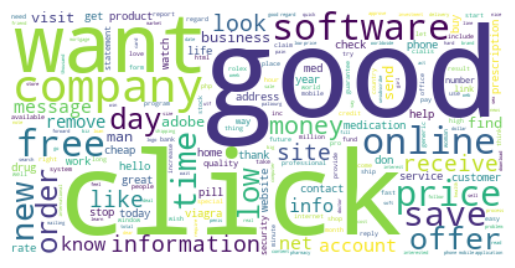

In [62]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

data['Tokens'] = emails

# spams
spams = data.loc[data['Label'] == 1, ['Tokens']]
spam_x = tf_vectorizer.fit_transform([" ".join(text) for text in spams['Tokens']]).toarray()

df = pd.DataFrame(spam_x.tolist(), columns=tf_vectorizer.get_feature_names_out())
df.head(10)

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

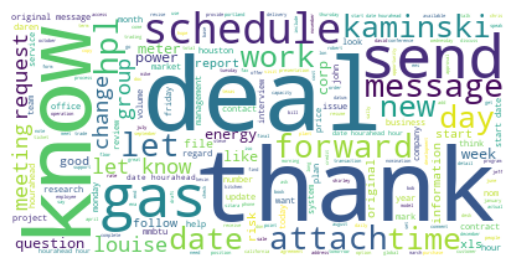

In [63]:
# hams
hams = data.loc[data['Label'] == 0, ['Tokens']]
ham_x = tf_vectorizer.fit_transform([" ".join(text) for text in hams['Tokens']]).toarray()

df = pd.DataFrame(ham_x.tolist(), columns=tf_vectorizer.get_feature_names_out())

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Split to train and test data
The split is needed for supervised algorithms and supervised deep learning. I'm going to expriment with supervised algorithms, trying each on CounVectorizer and on TF-IDF.

In [64]:
from sklearn.model_selection import train_test_split

# split to train and test data for CountVectorizer
x_train,x_test,y_train,y_test = train_test_split(bag_of_words, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# split to train and test data for TF-IDF
x2_train,x2_test,y2_train,y2_test = train_test_split(tf_idf, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# split to train and test data for embeddings
x3_train,x3_test,y3_train,y3_test = train_test_split(email_embeddings, np.asarray(data["Label"]), random_state=42, test_size=0.2)

# Classification algorithms (supervised learning)
https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2 <br />
As we can see, the worse results are given by Naive Bayes with CountVectorizer. Other algorithms are dealing more or less well. The best results are given by VotingClassifier. <br />
We see that embeddings indeed performs better.
## Evaluation metrics:
**Accuracy** = (True Positives + True Negatives) / (True Positives + False Positives + True Negatives + False Negatives) <br />
Accuracy measures the proportion of correct predictions made by the model out of the total number of predictions.


**Precision** = True Positives / (True Positives + False Positives) <br />
Precision measures the proportion of true positive predictions out of all the positive predictions made by the model.


**Recall** = True Positives / (True Positives + False Negatives) <br />
Recall measures the proportion of true positive predictions to the number of actual positives (true positives + false negatives).


**F1 Score** = 2 * (Precision * Recall) / (Precision + Recall) <br />
An F1 score reaches its best value at 1 (perfect precision and recall) and its worst value at 0.

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score

# printing statistics
def print_stats(y1, pred1, y2, pred2, title):
    
    cm1 = confusion_matrix(y1, pred1)
    cm2 = confusion_matrix(y2, pred2)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title)
    
    sns.heatmap(cm1, annot=True, fmt="d", linewidths=2, cmap="Greens", cbar=False, ax=ax[0])
    ax[0].set_title('Train set')
    ax[0].set_xlabel('Predicted');
    ax[0].set_ylabel('Real');
    ax[0].xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax[0].yaxis.set_ticklabels(['Ham', 'Spam']);
    
    sns.heatmap(cm2, annot=True, fmt="d", linewidths=2, cmap="Blues", cbar=False, ax=ax[1])
    ax[1].set_title('Test set')
    ax[1].set_xlabel('Predicted');
    ax[1].set_ylabel('Real');
    ax[1].xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax[1].yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()
    
    data = {
        'Accuracy': [
            "{:.2f}".format(balanced_accuracy_score(y1, pred1)), 
            "{:.2f}".format(balanced_accuracy_score(y2, pred2))],  
        'Precision': [
            "{:.2f}".format(precision_score(y1, pred1)), 
            "{:.2f}".format(precision_score(y2, pred2))], 
        'Recall': [
            "{:.2f}".format(recall_score(y1, pred1)), 
            "{:.2f}".format(recall_score(y2, pred2))],
        'F1 score': [
            "{:.2f}".format(f1_score(y1, pred1)), 
            "{:.2f}".format(f1_score(y2, pred2))] 
    }
    df = pd.DataFrame(data)
    df.index = ['Train', 'Test']
    print(df)

The algorithms are run three times: on bag of words, TF-IDF and word embeddings
## Gaussian Naive Bayes

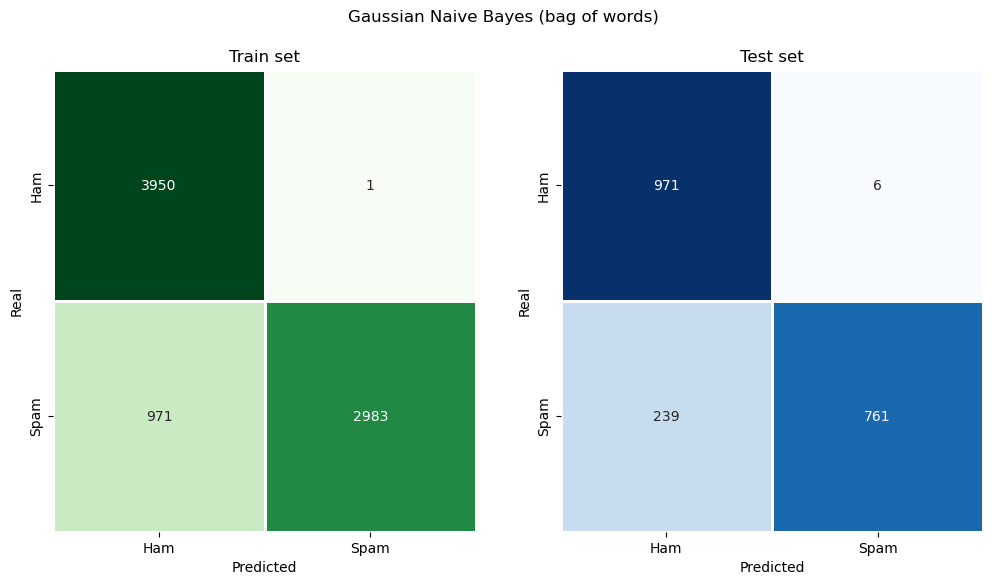

      Accuracy Precision Recall F1 score
Train     0.88      1.00   0.75     0.86
Test      0.88      0.99   0.76     0.86


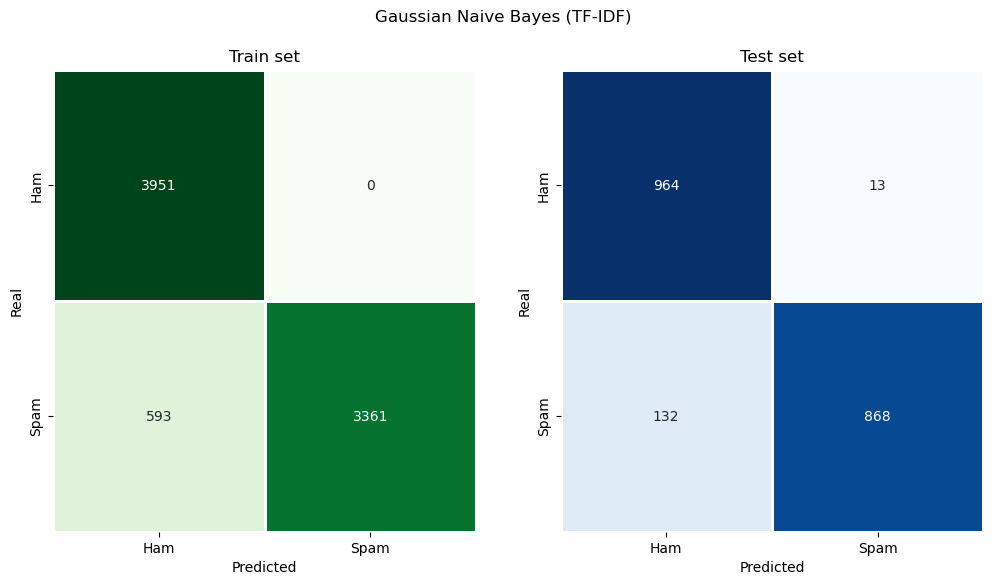

      Accuracy Precision Recall F1 score
Train     0.93      1.00   0.85     0.92
Test      0.93      0.99   0.87     0.92


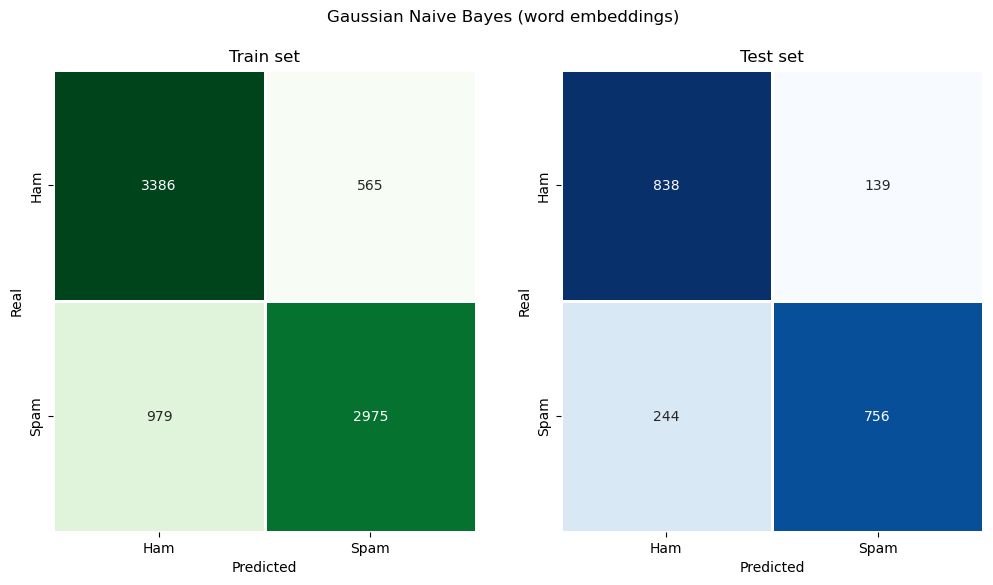

      Accuracy Precision Recall F1 score
Train     0.80      0.84   0.75     0.79
Test      0.81      0.84   0.76     0.80


In [66]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(x_train,y_train)
pred1 = NB.predict(x_train)
pred2 = NB.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Gaussian Naive Bayes (bag of words)")

NB2 = GaussianNB()
NB2.fit(x2_train,y2_train)
pred1 = NB2.predict(x2_train)
pred2 = NB2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Gaussian Naive Bayes (TF-IDF)")

NB3 = GaussianNB()
NB3.fit(x3_train,y3_train)
pred1 = NB3.predict(x3_train)
pred2 = NB3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Gaussian Naive Bayes (word embeddings)")

## Logistic regression

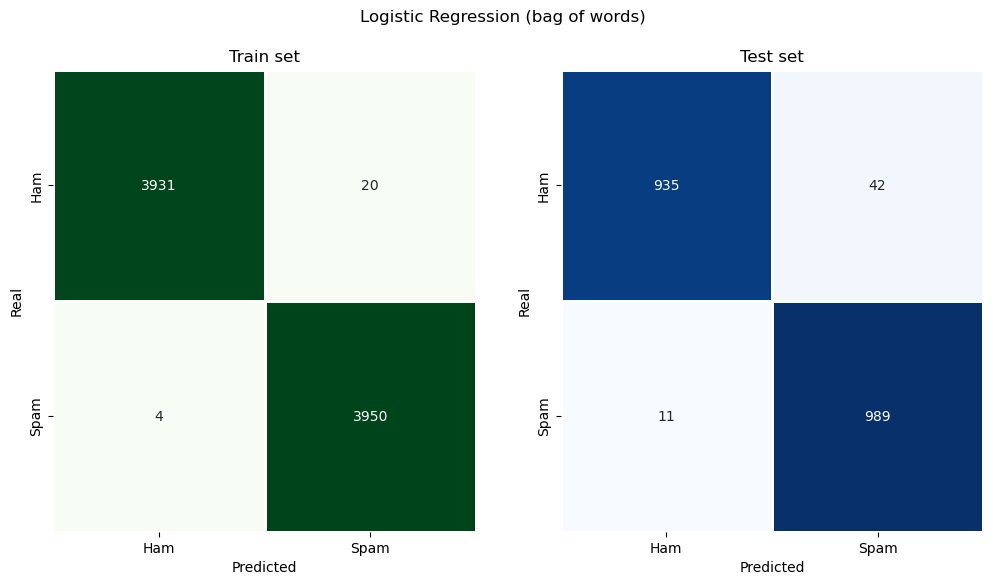

      Accuracy Precision Recall F1 score
Train     1.00      0.99   1.00     1.00
Test      0.97      0.96   0.99     0.97


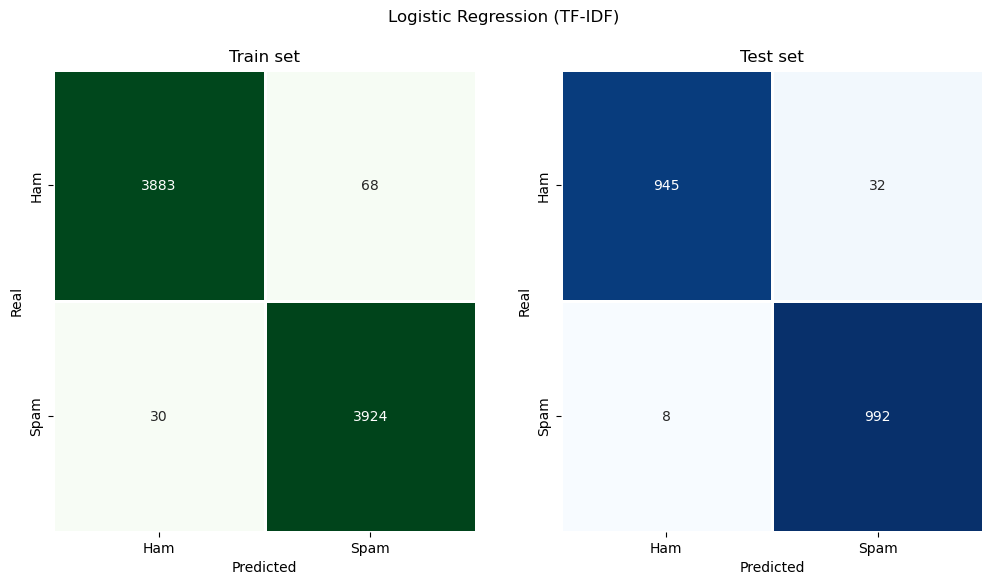

      Accuracy Precision Recall F1 score
Train     0.99      0.98   0.99     0.99
Test      0.98      0.97   0.99     0.98


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


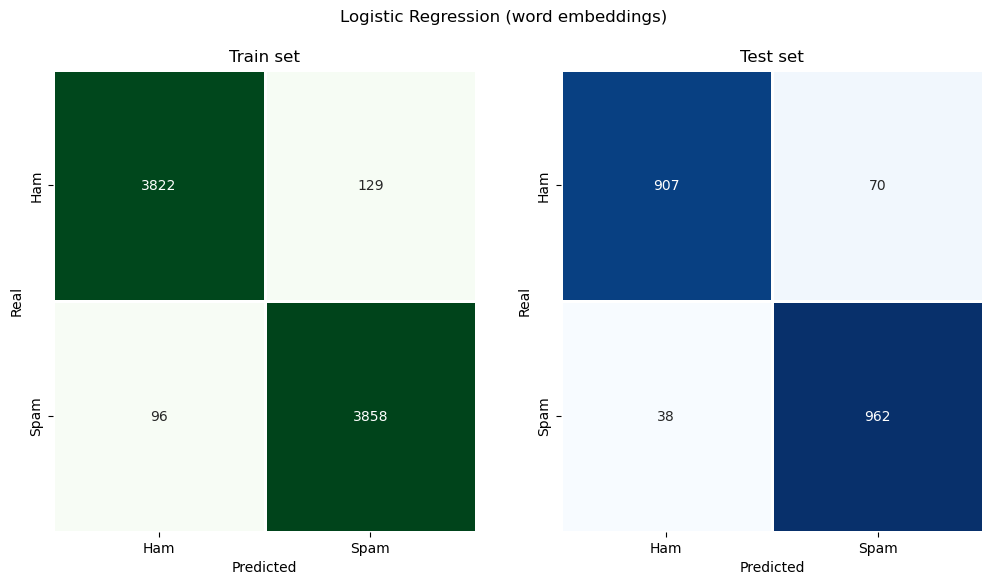

      Accuracy Precision Recall F1 score
Train     0.97      0.97   0.98     0.97
Test      0.95      0.93   0.96     0.95


In [67]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(x_train,y_train)
pred1 = LR.predict(x_train)
pred2 = LR.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Logistic Regression (bag of words)")

LR2 = LogisticRegression()
LR2.fit(x2_train,y2_train)
pred1 = LR2.predict(x2_train)
pred2 = LR2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Logistic Regression (TF-IDF)")

LR3 = LogisticRegression()
LR3.fit(x3_train,y3_train)
pred1 = LR3.predict(x3_train)
pred2 = LR3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Logistic Regression (word embeddings)")

## *k*-nearest neighbors

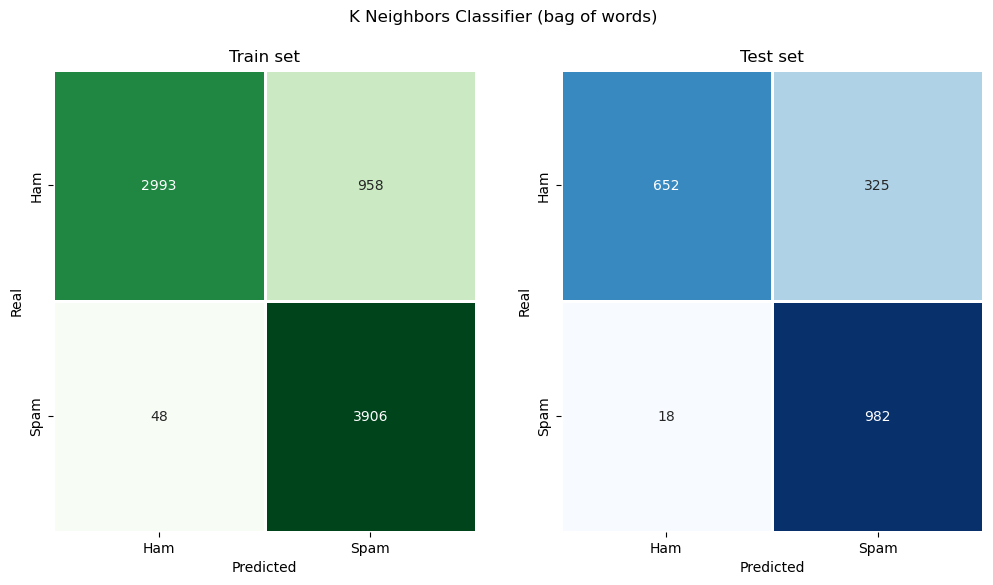

      Accuracy Precision Recall F1 score
Train     0.87      0.80   0.99     0.89
Test      0.82      0.75   0.98     0.85


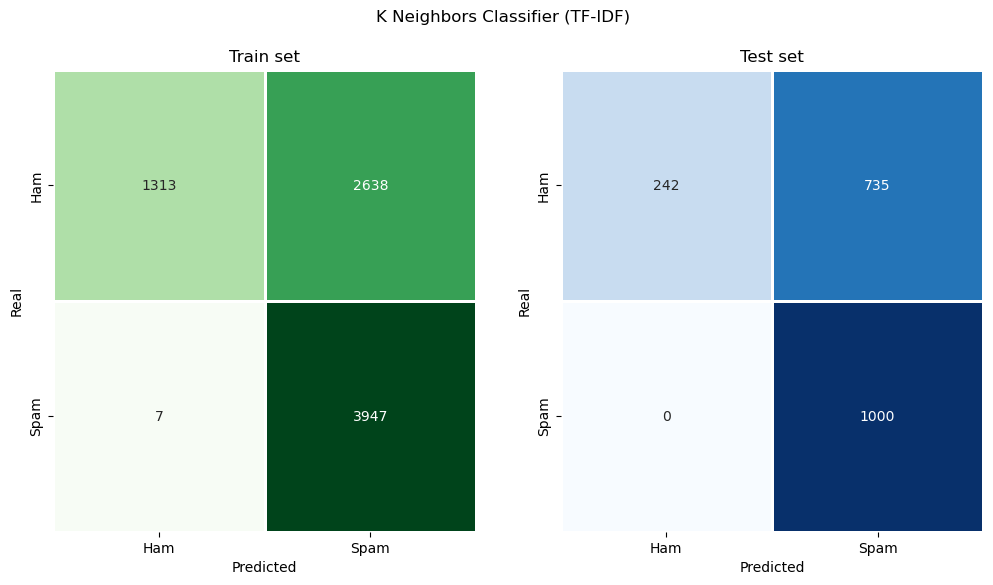

      Accuracy Precision Recall F1 score
Train     0.67      0.60   1.00     0.75
Test      0.62      0.58   1.00     0.73


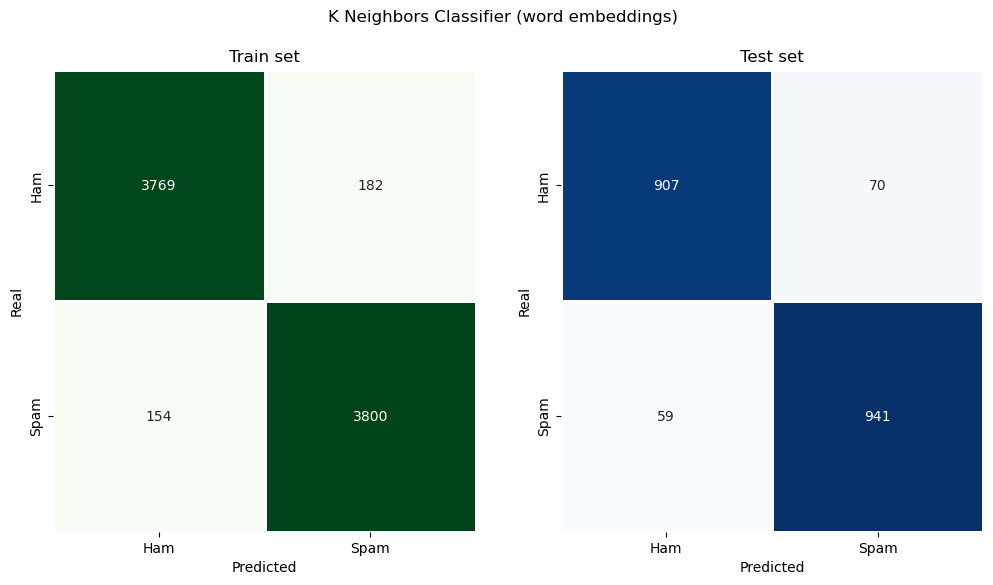

      Accuracy Precision Recall F1 score
Train     0.96      0.95   0.96     0.96
Test      0.93      0.93   0.94     0.94


In [68]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train,y_train)
pred1 = KNN.predict(x_train)
pred2 = KNN.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "K Neighbors Classifier (bag of words)")

KNN2 = KNeighborsClassifier()
KNN2.fit(x2_train,y2_train)
pred1 = KNN2.predict(x2_train)
pred2 = KNN2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "K Neighbors Classifier (TF-IDF)")

KNN3 = KNeighborsClassifier()
KNN3.fit(x3_train,y3_train)
pred1 = KNN3.predict(x3_train)
pred2 = KNN3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "K Neighbors Classifier (word embeddings)")

## Linear support vector

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


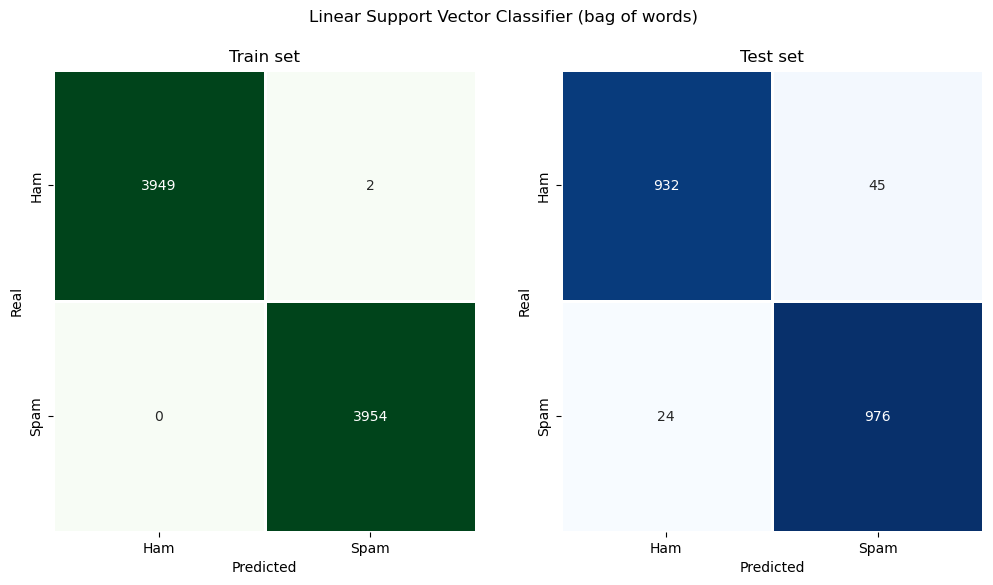

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.96      0.96   0.98     0.97


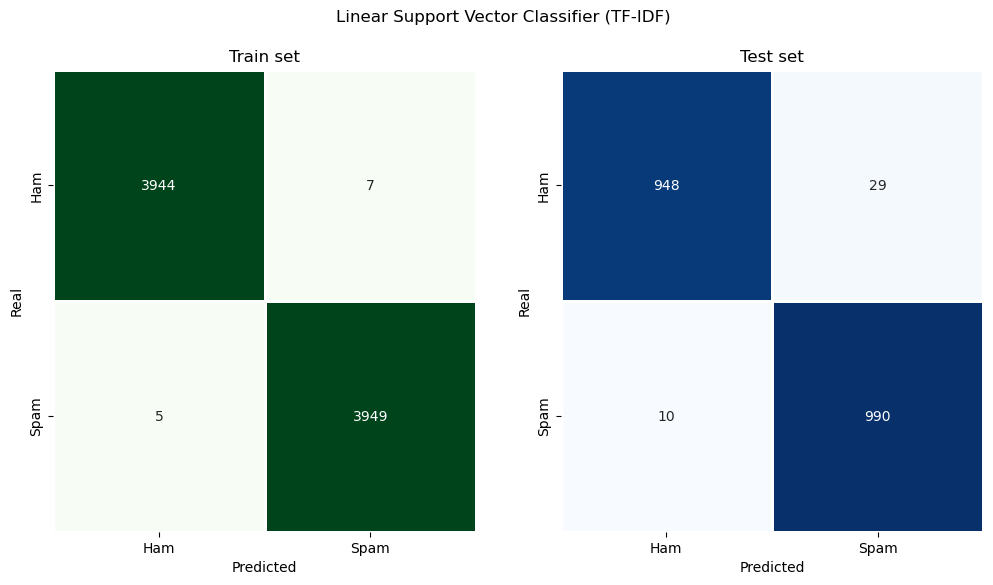

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.98      0.97   0.99     0.98


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


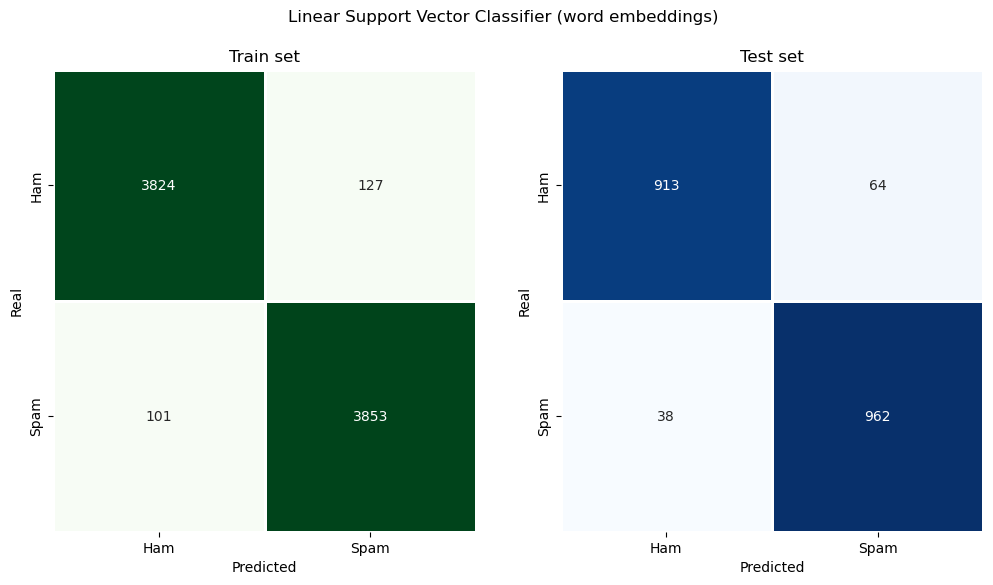

      Accuracy Precision Recall F1 score
Train     0.97      0.97   0.97     0.97
Test      0.95      0.94   0.96     0.95


In [69]:
from sklearn.svm import LinearSVC

SVC = LinearSVC(max_iter=2000)
SVC.fit(x_train,y_train)
pred1 = SVC.predict(x_train)
pred2 = SVC.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Linear Support Vector Classifier (bag of words)")

SVC2 = LinearSVC(max_iter=2000)
SVC2.fit(x2_train,y2_train)
pred1 = SVC2.predict(x2_train)
pred2 = SVC2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Linear Support Vector Classifier (TF-IDF)")

SVC3 = LinearSVC(max_iter=2000)
SVC3.fit(x3_train,y3_train)
pred1 = SVC3.predict(x3_train)
pred2 = SVC3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Linear Support Vector Classifier (word embeddings)")

## Decision tree

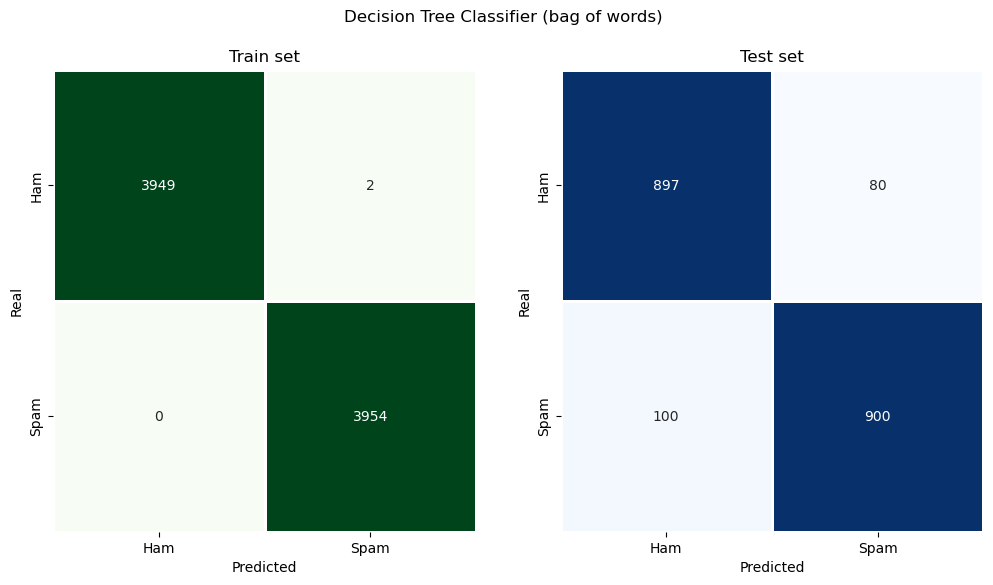

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.91      0.92   0.90     0.91


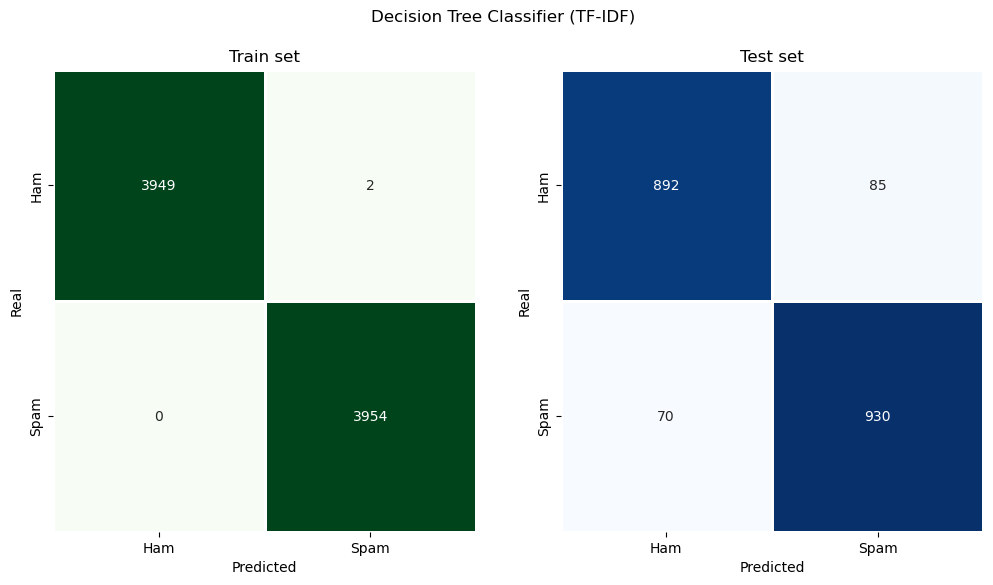

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.92      0.92   0.93     0.92


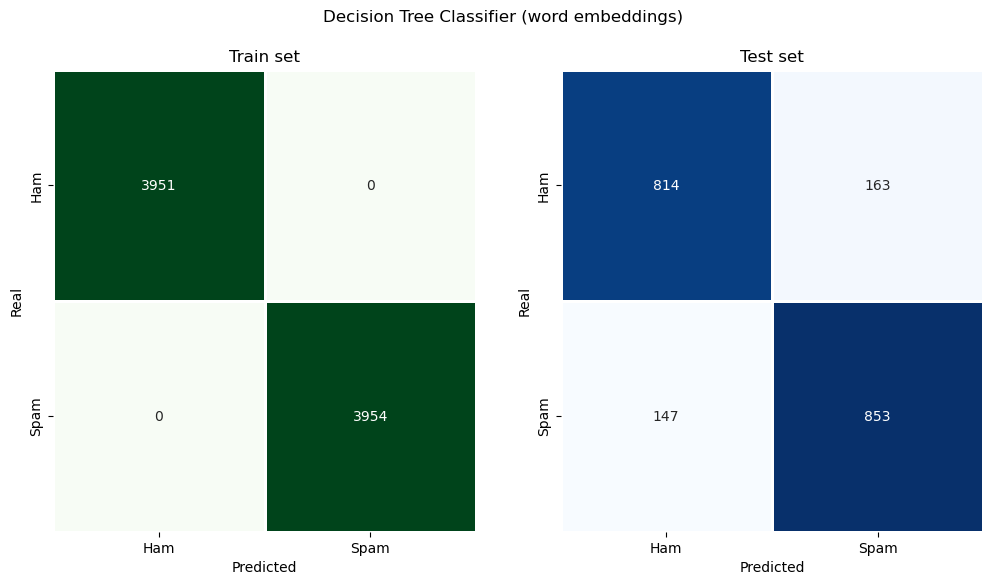

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.84      0.84   0.85     0.85


In [70]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(x_train,y_train)
pred1 = DTC.predict(x_train)
pred2 = DTC.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Decision Tree Classifier (bag of words)")

DTC2 = DecisionTreeClassifier()
DTC2.fit(x2_train,y2_train)
pred1 = DTC2.predict(x2_train)
pred2 = DTC2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Decision Tree Classifier (TF-IDF)")

DTC3 = DecisionTreeClassifier()
DTC3.fit(x3_train,y3_train)
pred1 = DTC3.predict(x3_train)
pred2 = DTC3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Decision Tree Classifier (word embeddings)")

## Random forest

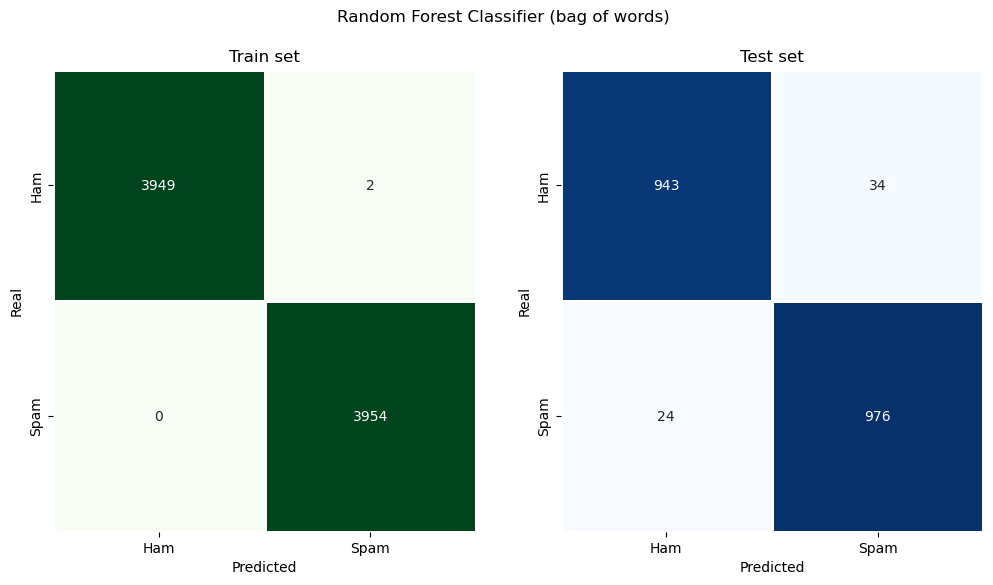

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.97      0.97   0.98     0.97


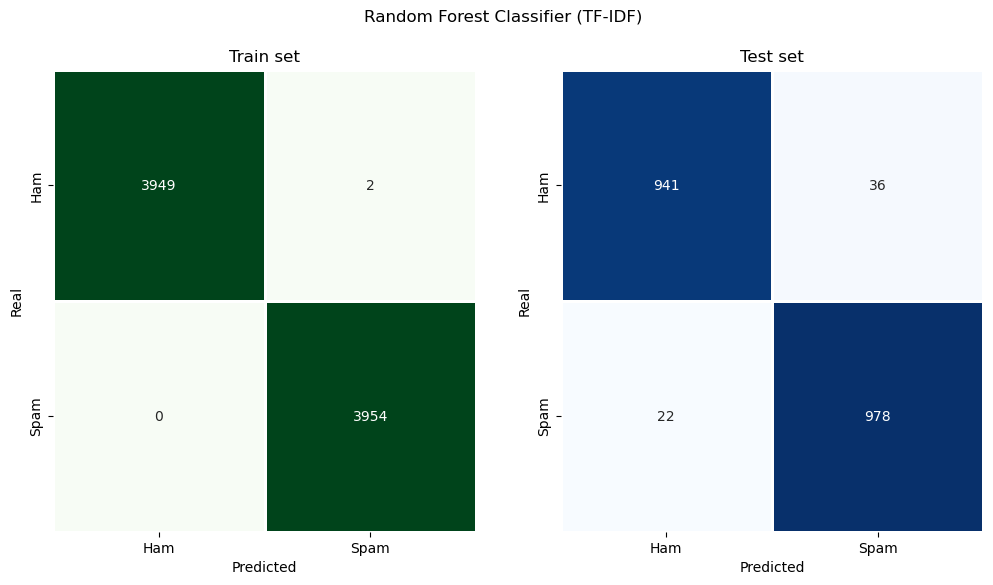

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.97      0.96   0.98     0.97


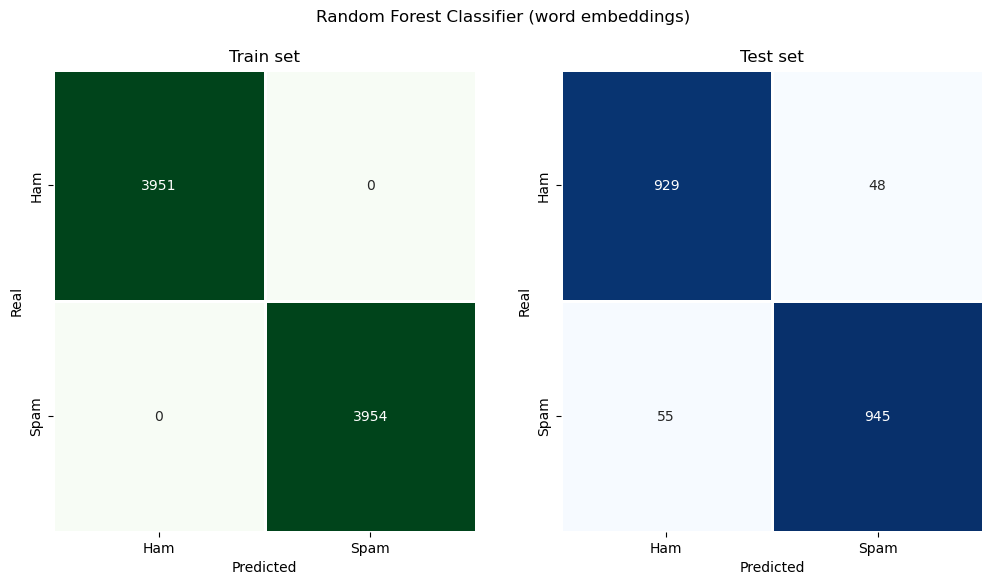

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.95      0.95   0.94     0.95


In [71]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(x_train,y_train)
pred1 = RFC.predict(x_train)
pred2 = RFC.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Random Forest Classifier (bag of words)")

RFC2 = RandomForestClassifier()
RFC2.fit(x2_train,y2_train)
pred1 = RFC2.predict(x2_train)
pred2 = RFC2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Random Forest Classifier (TF-IDF)")

RFC3 = RandomForestClassifier()
RFC3.fit(x3_train,y3_train)
pred1 = RFC3.predict(x3_train)
pred2 = RFC3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Random Forest Classifier (word embeddings)")

## Voting classifier

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


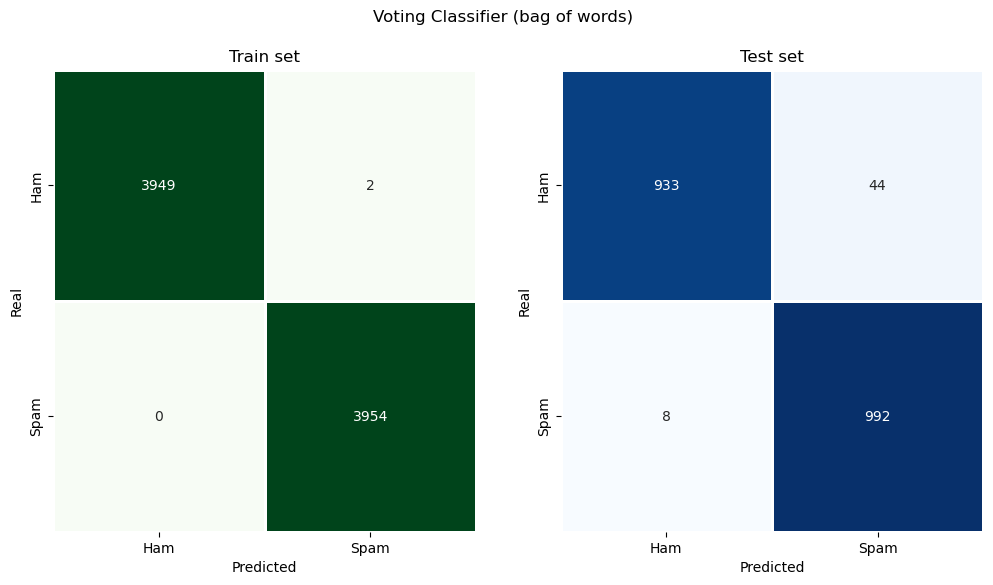

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.97      0.96   0.99     0.97


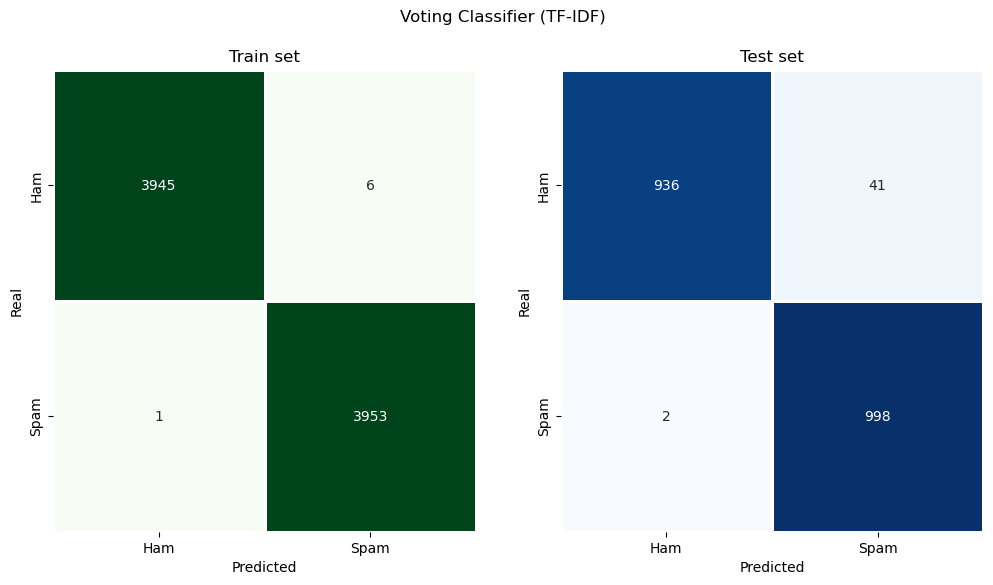

      Accuracy Precision Recall F1 score
Train     1.00      1.00   1.00     1.00
Test      0.98      0.96   1.00     0.98


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


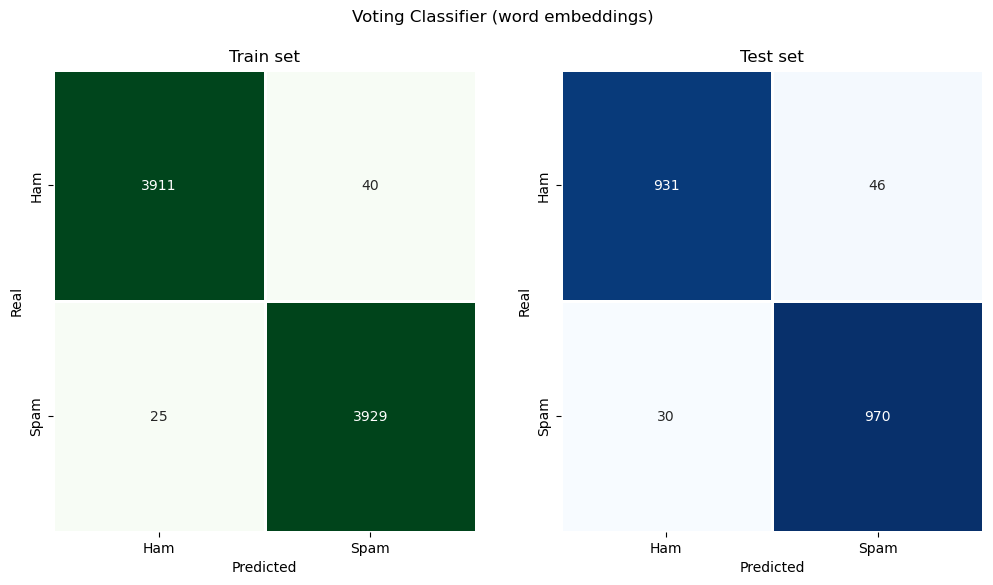

      Accuracy Precision Recall F1 score
Train     0.99      0.99   0.99     0.99
Test      0.96      0.95   0.97     0.96


In [72]:
from sklearn.ensemble import VotingClassifier

VC = VotingClassifier(estimators=[('LR',LR),('KNN',KNN),('DTC',DTC),('RFC',RFC),('SVC',SVC)], voting='hard')
VC.fit(x_train,y_train)
pred1 = VC.predict(x_train)
pred2 = VC.predict(x_test)
print_stats(y_train, pred1, y_test, pred2, "Voting Classifier (bag of words)")

VC2 = VotingClassifier(estimators=[('LR',LR2),('KNN',KNN2),('DTC',DTC2),('RFC',RFC2),('SVC',SVC2)], voting='hard')
VC2.fit(x2_train,y2_train)
pred1 = VC2.predict(x2_train)
pred2 = VC2.predict(x2_test)
print_stats(y2_train, pred1, y2_test, pred2, "Voting Classifier (TF-IDF)")

VC3 = VotingClassifier(estimators=[('LR',LR3),('KNN',KNN3),('DTC',DTC3),('RFC',RFC3),('SVC',SVC3)], voting='hard')
VC3.fit(x3_train,y3_train)
pred1 = VC3.predict(x3_train)
pred2 = VC3.predict(x3_test)
print_stats(y3_train, pred1, y3_test, pred2, "Voting Classifier (word embeddings)")

# Unsupervised algorithms 

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score

# printing statistics
def print_single_stats(y, pred, title):
    conf = confusion_matrix(y_pred=pred,y_true=y)
    plt.title(title)
    ax=plt.subplot()
    sns.heatmap(conf, annot=True, fmt="d", linewidths=2, cmap="Greens", cbar=False)
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()
    
    data = {
        'Accuracy': [
            "{:.2f}".format(balanced_accuracy_score(y, pred))],  
        'Precision': [
            "{:.2f}".format(precision_score(y, pred))], 
        'Recall': [
            "{:.2f}".format(recall_score(y, pred))],
        'F1 score': [
            "{:.2f}".format(f1_score(y, pred))] 
    }
    df = pd.DataFrame(data)
    df.index = ['Test']
    print(df)

## PCA
Sometimes PCA can improve the scores.

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
tf_idf_pca = pca.fit_transform(tf_idf)

x2_train_pca,x2_test_pca,y2_train_pca,y2_test_pca = train_test_split(tf_idf_pca, np.asarray(data["Label"]), random_state=42, test_size=0.2)

## One-class SVM
Each entry is either 1 for normal data or -1 for an anomaly. <br/>
One-class SVM is trained on the normal data only, and tested on test set.

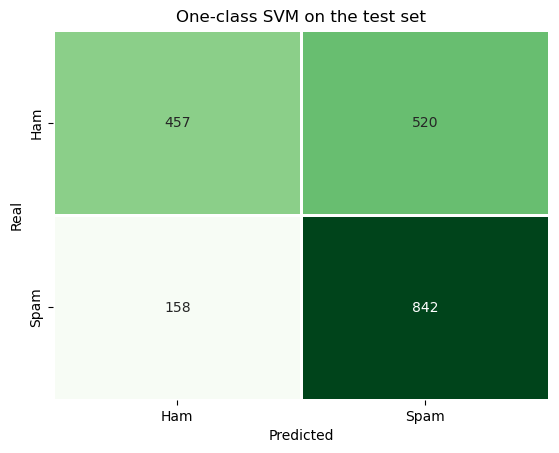

     Accuracy Precision Recall F1 score
Test     0.65      0.62   0.84     0.71


In [75]:
from sklearn.svm import OneClassSVM

# train only on normal data
x_train_normal = x2_train_pca[y2_train == 0]

OCSVM = OneClassSVM(kernel='sigmoid', nu=0.5, gamma='auto')
OCSVM.fit(x_train_normal)
pred = np.array([1 if p == -1 else 0 for p in OCSVM.predict(x2_test_pca)])
print_single_stats(y2_test_pca, pred, "One-class SVM on the test set")

## Local Outlier Factor
Local outlier factor can be used in two ways: build a new model for the whole dataset each time, or fit it on the normal data only, and predict it on different sets.

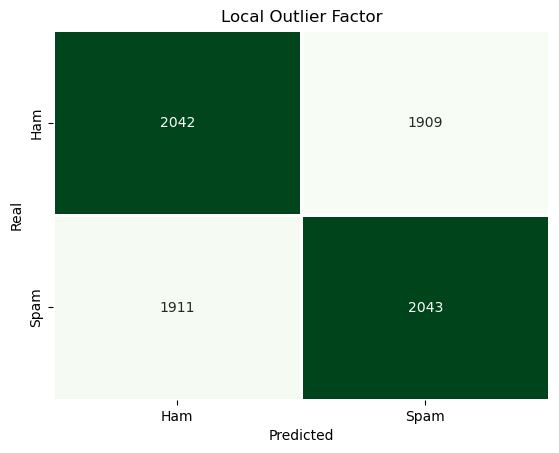

     Accuracy Precision Recall F1 score
Test     0.52      0.52   0.52     0.52


In [76]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=10, contamination=0.5)
pred = np.array([1 if p == -1 else 0 for p in LOF.fit_predict(x2_train_pca)])
print_single_stats(y2_train_pca, pred, "Local Outlier Factor")

## Isolation Forest

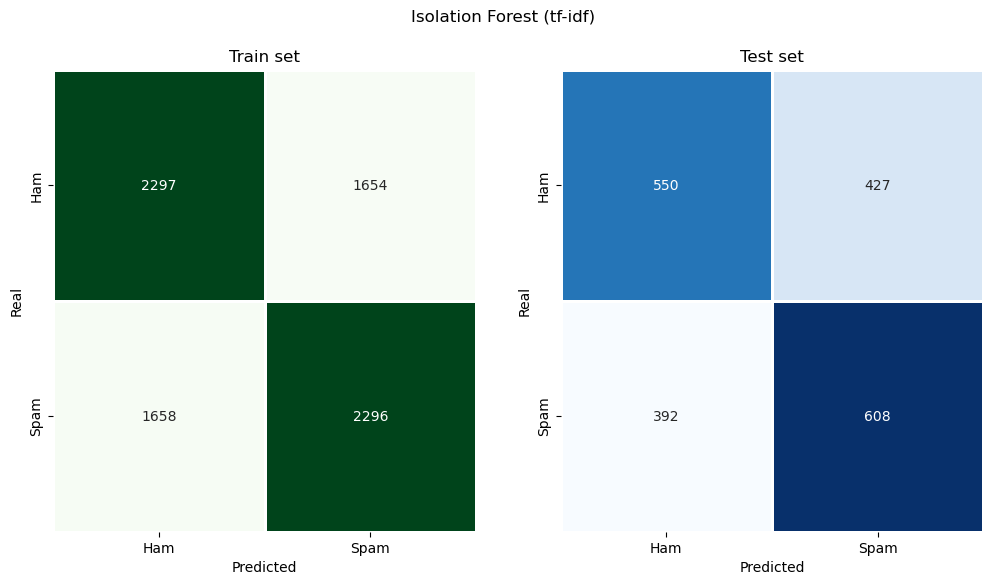

      Accuracy Precision Recall F1 score
Train     0.58      0.58   0.58     0.58
Test      0.59      0.59   0.61     0.60


In [77]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=30, max_samples=32, contamination=0.50)
IF.fit(x2_train_pca)
pred1 = np.array([1 if p == -1 else 0 for p in IF.predict(x2_train_pca)])
pred2 = np.array([1 if p == -1 else 0 for p in IF.predict(x2_test_pca)])
print_stats(y2_train_pca, pred1, y2_test_pca, pred2, "Isolation Forest (tf-idf)")

## Gaussian Mixture Model
https://vitalflux.com/gaussian-mixture-models-what-are-they-when-to-use/ <br/>
https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4 (also determining appropriate number of clusters)<br/>
https://github.com/vlavorini/ClusterCardinality/blob/master/Cluster%20Cardinality.ipynb<br/>
https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms<br/>
https://stats.stackexchange.com/questions/349258/correct-number-of-components-in-gmm-according-to-bic-and-aic-plots<br/>
https://stats.stackexchange.com/questions/368560/elbow-test-using-aic-bic-for-identifying-number-of-clusters-using-gmm<br/>
https://grabngoinfo.com/how-to-decide-the-number-of-clusters-data-science-interview-questions-and-answers/
Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC) scores

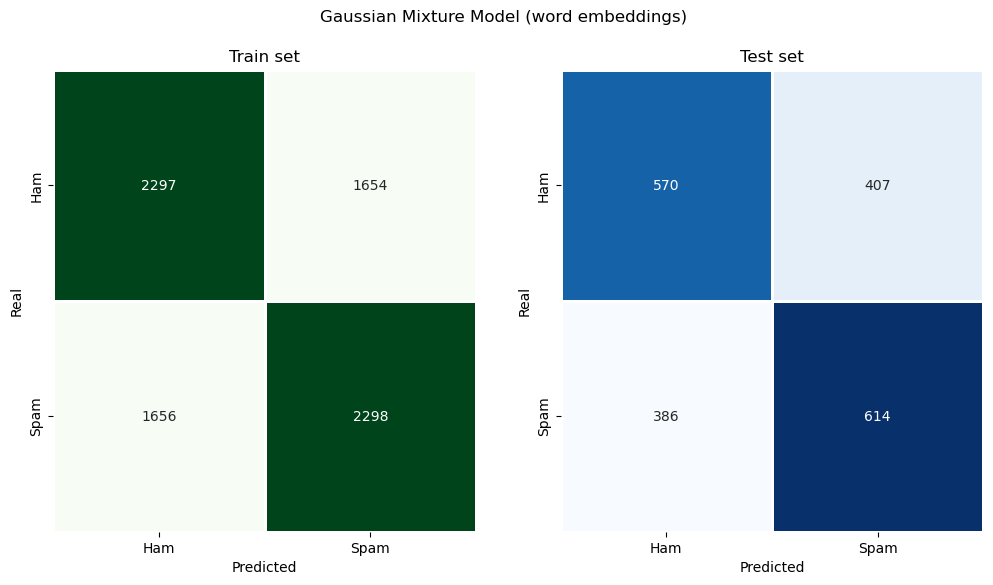

      Accuracy Precision Recall F1 score
Train     0.58      0.58   0.58     0.58
Test      0.60      0.60   0.61     0.61


In [78]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components=1, covariance_type='spherical', random_state=42)
GMM.fit(x2_train_pca)
scores = GMM.score_samples(x2_train_pca)
threshold = np.percentile(scores, 50)
pred1 = np.array([1 if score < threshold else 0 for score in GMM.score_samples(x2_train_pca)])
pred2 = np.array([1 if score < threshold else 0 for score in GMM.score_samples(x2_test_pca)])
print_stats(y2_train_pca, pred1, y2_test_pca, pred2, "Gaussian Mixture Model (word embeddings)")

## K-Means
https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py <br />
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/ <br />
https://stackoverflow.com/a/69024239 <br/>
https://stackoverflow.com/a/27586132 <br />
https://www.dataknowsall.com/textclustering.html <br />
https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook <br />
https://medium.com/@jwbtmf/visualizing-data-using-k-means-clustering-unsupervised-machine-learning-8b59eabfcd3d <br />
For choosing the appropriate number of clusters, we can use Elbow method or Silhouette score. Let's use Elbow method.

In [79]:
# finding number of clusters with Elbow method
# very long
# from sklearn.cluster import KMeans

# ks = range(1, 10)
# inertias = []
# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     # Fit model to samples
#     kmeans.fit(x2_train)
#     # Append the inertia to the list of inertias
#     inertias.append(kmeans.inertia_)

# # Plot ks vs inertias
# plt.plot(ks, inertias, '-o')
# plt.xlabel('number of clusters')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()

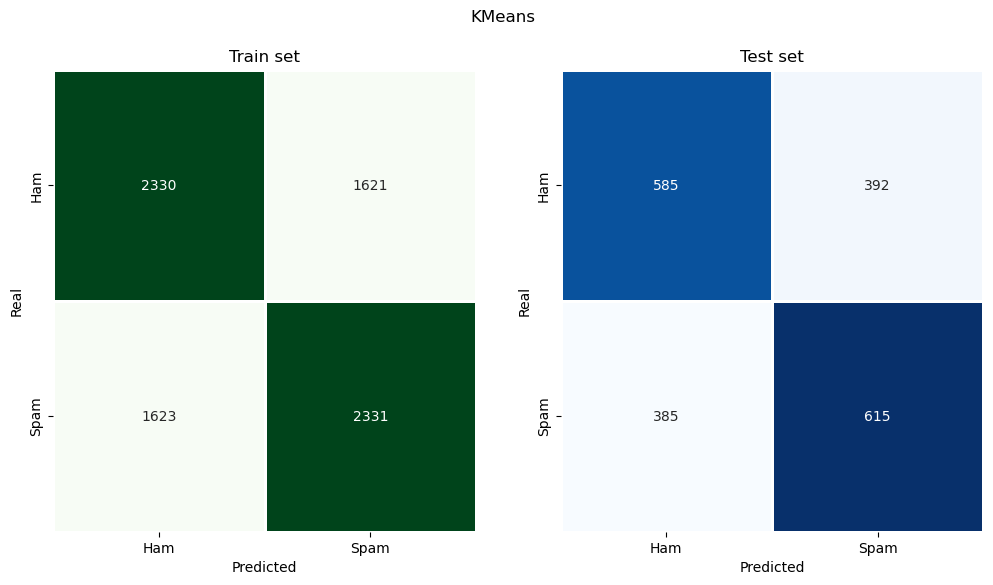

      Accuracy Precision Recall F1 score
Train     0.59      0.59   0.59     0.59
Test      0.61      0.61   0.61     0.61


In [80]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(x2_train_pca)

# anomalies are far from the clusters' centers
centroids = kmeans.cluster_centers_
distances = cdist(x2_train_pca, centroids, 'euclidean')
min_distances = distances[np.arange(len(distances)), labels]
threshold = np.percentile(min_distances, 50)
pred1 = np.array([1 if d > threshold else 0 for d in min_distances])

labels = kmeans.predict(x2_test_pca)
centroids = kmeans.cluster_centers_
distances = cdist(x2_test_pca, centroids, 'euclidean')
min_distances = distances[np.arange(len(distances)), labels]
pred2 = np.array([1 if d > threshold else 0 for d in min_distances])

print_stats(y2_train_pca, pred1, y2_test_pca, pred2, "KMeans")

# Deep learning (unsupervised)
(subset of machine learning algorithms)<br/>
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

def print_stats(predictions, X, y, title):
    # Generate the classification report
    report = classification_report(y, predictions, target_names=['Ham', 'Spam'])
    print(report)

    # Generate the confusion matrix
    conf = confusion_matrix(y, predictions)
    plt.title(title)
    ax= plt.subplot()
    sns.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()

In [82]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
x3_train = scaler.fit_transform(x3_train)
x3_test = scaler.transform(x3_test)

## Autoencoder
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

In [83]:
import tensorflow as tf
from tensorflow.keras import layers, losses

X_train,X_valid,Y_train,Y_valid = train_test_split(x3_train, y3_train, random_state=42, test_size=0.2)

# Keep only the normal data for the training dataset
X_train_normal = X_train[Y_train == 0]
X_valid_normal = X_valid[Y_valid == 0]

# Input layer
input = tf.keras.layers.Input(shape=(x3_train.shape[1],))

# Encoder layers
encoder = Sequential([
    layers.Dense(256, activation='relu'),  
    layers.Dense(128, activation='relu'),  
    layers.Dense(64, activation='relu'),  
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu')])(input)

# Decoder layers
decoder = tf.keras.Sequential([
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(300, activation="sigmoid")])(encoder)

# Create the autoencoder
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(X_train_normal, X_train_normal, 
                          epochs=20, 
                          batch_size=256,
                          validation_data=(X_valid_normal, X_valid_normal),
                          shuffle=True)

NameError: name 'Sequential' is not defined

In [ ]:
# Calculate MAE loss for validation data
valid_predictions = autoencoder.predict(X_valid_normal)
valid_loss = np.mean(np.abs(valid_predictions - X_valid_normal), axis=1)
threshold = np.percentile(valid_loss, 50)

# Detect anomalies in the train set
train_predictions = autoencoder.predict(x3_train)
train_loss = np.mean(np.abs(train_predictions - x3_train), axis=1)
train_loss = train_loss.reshape((-1))
predictions = np.array([1 if loss > threshold else 0 for loss in train_loss])
print_stats(predictions, x3_train, y3_train, "Autoencoder on train set")

# Detect anomalies in the test set
test_predictions = autoencoder.predict(x3_test)
test_loss = np.mean(np.abs(test_predictions - x3_test), axis=1)
test_loss = test_loss.reshape((-1))
predictions = np.array([1 if loss > threshold else 0 for loss in test_loss])
print_stats(predictions, x3_test, y3_test, "Autoencoder on test set")